In [7]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import zip_longest
import numpy as np
# from tabulate import tabulate

# For latex graphs
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

def plot_all_both(method):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(w=5.39749, h=6)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis", "bacteriuria", "telehealth"]
    for name in names:
        effort_accuracy_plot(name, method, True, axs[0])
        effort_accuracy_plot(name, method, False, axs[1])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()

def plot_all(method, show_all=True):
    fig = plt.figure()
    fig.set_size_inches(w=5.39749, h=3)
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis", "bacteriuria", "telehealth"]
    sns.set(style="whitegrid")
    for name in names:
        effort_accuracy_plot(name, method, show_all)
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    # plt.show()
    
# Get the accuracy at a threshold effort
def get_accuracy(name, method, effort):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    avg_effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_effort>=effort)
    return avg_accuracy[index]

def get_effort(name, method, accuracy):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1)
    
    # Find lowest index where accuracy exceeds or equals the accuracy
    index = np.argmax(avg_accuracy>=accuracy)
    return effort[index]

def get_effort_average_alternative(name, method, threshold_accuracy):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Array to store all effort readings
    required_efforts = []
    # For each effort get value at threshold
    for accuracy_list in stats_df.accuracy:
            # Find lowest index where accuracy exceeds or equals the accuracy
            accuracy_list = np.array(accuracy_list)
            index = np.argmax(accuracy_list>=threshold_accuracy)
            required_efforts.append(effort[index])
    # Average all accuracy data points over the 10 iterations
    avg_effort = np.nanmean(np.array(required_efforts))
    return avg_effort
    
def print_table(method):
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        row = [name]
        for accuracy in accuracies:
            row.append(get_effort(name, method, accuracy))
        table.append(row)
    print(tabulate(table, tablefmt='latex', floatfmt=".2f"))
    
def plot_table():
    table = []
    accuracies = [0.5, 0.75, 0.9, 1.0]
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        for accuracy in accuracies:
            table.append([name, accuracy, get_effort(name, accuracy)])
    df = pd.DataFrame(table, columns=["name", "accuracy", "effort"])
    sns.set(style="whitegrid", rc={'figure.figsize':(5.39749, 3)})
    sns.barplot(x="accuracy", y="effort", hue="name", data=df)
    plt.xlabel("accuracy threshold")

def effort_accuracy_plot(name, method, show_all=True, plot=plt):
    stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()

    # Add values to show all
    if (show_all):
        effort.append(1)
        avg_accuracy.append(max(avg_accuracy))


    # Make plot look nice
    plt.xlabel("effort")
    plt.ylabel("accuracy")
    plot.plot(effort, avg_accuracy, label=name, linewidth=2)

In [8]:
get_effort_average_alternative("copper", "bloom-1b7-last", 0.95)

0.07528735632183908

# BLOOM-1B7 Analysis

In [6]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def prepare_dataframe():
    datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]

    model_name = "bloom-1b7-last-five"

    df_datasets = pd.DataFrame()

    def get_all_efforts(name, method, threshold_accuracy):
        required_efforts = []

        stats_df = pd.read_csv("stats/stats-" + name + "-" + method + ".csv")
        # Convert csv lists to actual lists
        stats_df.effort = stats_df.effort.apply(literal_eval)
        stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

        # Find longest effort array
        effort = max(stats_df.effort, key=len)
        for accuracy_list in stats_df.accuracy:
            # Find lowest index where accuracy exceeds or equals the accuracy
            accuracy_list = np.array(accuracy_list)
            index = np.argmax(accuracy_list>=threshold_accuracy)
            required_efforts.append(effort[index])

        return required_efforts

    for dataset in datasets:
        df_datasets[dataset] = get_all_efforts(dataset, model_name, 1.0)
    df_datasets.head(20)

    df_datasets = pd.melt(df_datasets, value_vars=datasets, var_name="dataset")
    df_datasets.head(20)
    return df_datasets

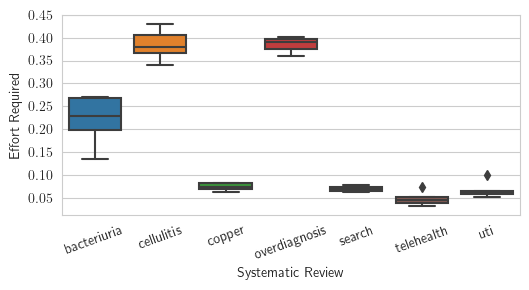

In [7]:
df = prepare_dataframe()

fig = plt.figure()
sns.set_style("whitegrid")
ax =sns.boxplot(data=df, x="dataset", y="value")

ax.yaxis.set_major_locator(MultipleLocator(0.05))

plt.xlabel("Systematic Review")
ax.tick_params(axis='x', labelrotation = 20)
plt.ylabel("Effort Required")

fig.set_size_inches(w=5.39749, h=3)
fig.tight_layout()

# plt.savefig('../honours/thesis/Figures/bloom-1b7-box.pgf')
plt.show()

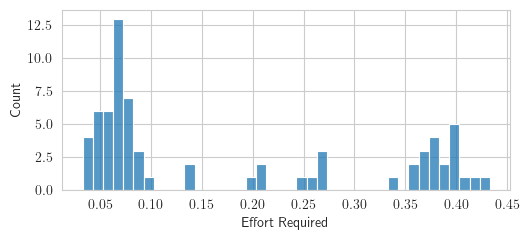

In [92]:
df = prepare_dataframe()

fig = plt.figure()
sns.set_style("whitegrid")
ax = sns.histplot(data=df, x="value", binwidth=0.01)

plt.xlabel("Effort Required")

fig.set_size_inches(w=5.39749, h=2.5)
fig.tight_layout()

# plt.savefig('../honours/thesis/Figures/bloom-1b7-dist.pgf')
plt.show()

# Final

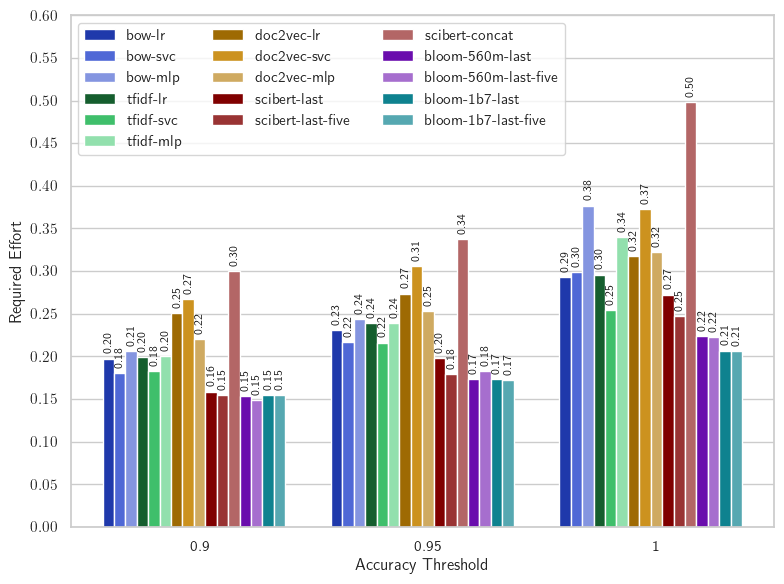

In [10]:
# BAR CHART

model_names = []

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)
        
transformer_models = [
    "scibert-last",
    "scibert-last-five",
    "scibert-concat",
    "bloom-560m-last",
    "bloom-560m-last-five",
    "bloom-1b7-last",
    "bloom-1b7-last-five"
]
for model in transformer_models:
    model_names.append(model)

def get_average_effort_at_accuracy(model_name, accuracy):
    efforts = []
    for dataset in datasets:
        efforts.append(get_effort(dataset, model_name, accuracy))
    # Return average
    standard_deviation = np.std(efforts, ddof=1)
    standard_error = standard_deviation / np.sqrt(np.size(efforts))
    average = sum(efforts) / len(efforts)
    return [average, standard_error, standard_deviation]

# Plot bar plot of average model performance
colormap = [
    # Blues
    "#1f39ab",
    "#4f68d6",
    "#8495e0",
    # Greens
    "#155e2e",
    "#3fbf6b",
    "#92e0ad",
    # Oranges
    "#9e6a03",
    "#cc921f",
    "#cfaa61",
    # Reds
    "#800000",
    "#993333",
    "#b36666",
    # Purples
    "#6a0dad",
    "#a66ece",
    # Teals
    "#0e828f",
    "#56a8b1"
]
accuracy_thresholds = [0.9, 0.95, 1]
width = 0.8 # the width of the bars

x = np.arange(len(accuracy_thresholds))  # the label locations
fig, ax = plt.subplots()
sns.set(style="whitegrid")
ax.xaxis.grid(False)
rects = []

length = len(model_names)
for i, model_name in enumerate(model_names):
    required_efforts = []
    standard_errors = []
    for accuracy in accuracy_thresholds:
        temp = get_average_effort_at_accuracy(model_name, accuracy)
#         print("{} at {} accuracy: {:.2f} ({:.2f} S.E.)".format(model_name, accuracy, temp[0], temp[1]))
        required_efforts.append(temp[0])
        standard_errors.append(temp[1])
    
    color=colormap[i%16]
    i = i - len(model_names)/2 # Offset bar to left
    rects.append(ax.bar(x + i * (width/length), required_efforts, width/length, label=model_name, color=color))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy Threshold')
ax.set_ylabel('Required Effort')
ax.set_xticks(x, accuracy_thresholds)
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.legend(ncol=3, loc='upper left')
# ax.legend()

for container in ax.containers:
    ax.bar_label(container, padding=3, fmt='%.2f', verticalalignment='center', fontsize=8, rotation=90)

fig.set_size_inches(w=8, h=6)
plt.yticks(np.arange(0, 0.61, 0.05))
fig.tight_layout()

# plt.savefig('../honours/thesis/Figures/effort-accuracy-all-bar.pgf')
plt.show()

In [ ]:
# Plot all models on one plot
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import numpy as np
from itertools import zip_longest
import math

# Create nine polar axes and access them through the returned array
fig, axs = plt.subplots(6, 3, sharex=True, sharey=True)
# Set common labels
fig.text(0.55, 0.02, 'Effort', ha='center', va='center')
fig.text(0.02, 0.4, 'Accuracy', ha='center', va='center', rotation='vertical')
sns.set(style="whitegrid")

model_names = []

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)
        
transformer_models = [
    "scibert-last",
    "scibert-last-five",
    "scibert-concat",
    "bloom-560m-last",
    "bloom-560m-last-five",
    "bloom-1b7-last",
    "bloom-1b7-last-five"
]
for model in transformer_models:
    model_names.append(model)

# Empty subplots
axs[4, 2].axis('off')
axs[5, 2].axis('off')
    
for i, model in enumerate(model_names):
    j = i % 3
    i = math.floor(i / 3)
    # Edge cases for bloom models
    if i == 4 and j == 2:
        i = 5
        j = 0
    elif i == 5 and j == 0:
        j = 1
        
    for dataset in datasets:
        stats_df = pd.read_csv("stats/stats-" + dataset + "-" + model + ".csv")
        # Convert csv lists to actual lists
        stats_df.effort = stats_df.effort.apply(literal_eval)
        stats_df.accuracy = stats_df.accuracy.apply(literal_eval)
        # Find longest effort array
        effort = max(stats_df.effort, key=len)
        # Average all accuracy data points over the 10 iterations
        avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()
        axs[i,j].plot(effort, avg_accuracy, label=dataset, linewidth=1)
        axs[i,j].set_title(model)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1,0.08),loc='lower right')
axs[0,0].set_xticks((np.arange(0, 0.8, 0.2)))
axs[0,0].set_yticks((np.arange(0.2, 1.01, 0.2)))
fig.set_size_inches(w=5.39749, h=8)
fig.tight_layout()

plt.subplots_adjust(left=0.1, bottom=0.08, top=0.95, right=1)

# plt.savefig('../honours/thesis/Figures/effort-accuracy-all.pgf')
plt.show()

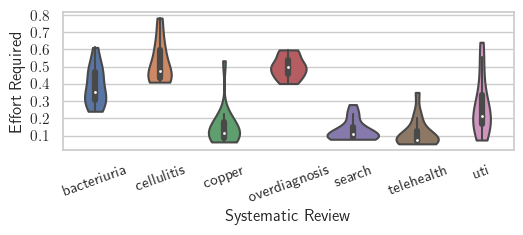

In [12]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

model_names = []

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)
        
transformer_models = [
    "scibert-last",
    "scibert-last-five",
    "scibert-concat",
    "bloom-560m-last",
    "bloom-560m-last-five",
    "bloom-1b7-last",
    "bloom-1b7-last-five"
]
for model in transformer_models:
    model_names.append(model)
    
def get_average_effort(efforts):
    # Return average
    standard_deviation = np.std(efforts, ddof=1)
    standard_error = standard_deviation / np.sqrt(np.size(efforts))
    average = sum(efforts) / len(efforts)
    return [average, standard_error, standard_deviation]
    
df_datasets = pd.DataFrame()
    
for dataset in datasets:
    efforts = []
    for model in model_names:
        efforts.append(get_effort(dataset, model, 1.0))
    df_datasets[dataset] = efforts
    
df_datasets["model_name"] = model_names
df_datasets.head(20)

df_datasets = pd.melt(df_datasets, id_vars="model_name", value_vars=datasets, var_name="dataset")
df_datasets.head()

fig = plt.figure()
sns.set_style("whitegrid")
ax =sns.violinplot(data=df_datasets, x="dataset", y="value", cut=0)

ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

plt.xlabel("Systematic Review")
ax.tick_params(axis='x', labelrotation = 20)
plt.ylabel("Effort Required")

fig.set_size_inches(w=5.39749, h=2.5)
fig.tight_layout()

# plt.savefig('../honours/thesis/Figures/effort-systematic-reviews.pgf')
plt.show()

In [25]:
df_datasets = pd.DataFrame()
    
for dataset in datasets:
    efforts = []
    for model in model_names:
        efforts.append(get_effort(dataset, model, 1.0))
    df_datasets[dataset] = efforts
    
df_datasets["model_name"] = model_names
df_datasets.head(20)

df_datasets = df_datasets.quantile([0, .25, .5, 0.75, 1])

def latex_with_lines(df, *args, **kwargs):
    kwargs['column_format'] = '|'.join([''] + ['l'] * df.index.nlevels
                                            + ['r'] * df.shape[1] + [''])
    res = df.to_latex(*args, **kwargs)
    return res.replace('\\\\\n', '\\\\ \\midrule\n')

# print(df_datasets.style.to_latex(clines="all;data"))
# print(latex_with_lines(df_datasets))
print(df_datasets.to_latex(float_format="%.2f"))

df_datasets

\begin{tabular}{lrrrrrrr}
\toprule
{} &  bacteriuria &  cellulitis &  copper &  overdiagnosis &  search &  telehealth &  uti \\
\midrule
0.00 &         0.24 &        0.41 &    0.06 &           0.40 &    0.08 &        0.05 & 0.07 \\
0.25 &         0.31 &        0.43 &    0.09 &           0.46 &    0.09 &        0.07 & 0.17 \\
0.50 &         0.35 &        0.47 &    0.12 &           0.50 &    0.11 &        0.08 & 0.22 \\
0.75 &         0.47 &        0.60 &    0.18 &           0.54 &    0.15 &        0.13 & 0.34 \\
1.00 &         0.61 &        0.78 &    0.53 &           0.60 &    0.28 &        0.35 & 0.64 \\
\bottomrule
\end{tabular}



C:\Users\Connor\AppData\Local\Temp\ipykernel_7148\2713757922.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_datasets.to_latex(float_format="%.2f"))


,bacteriuria,cellulitis,copper,overdiagnosis,search,telehealth,uti
0.00,0.241176,0.410299,0.063218,0.402130,0.078668,0.052097,0.074141
0.25,0.308824,0.432724,0.085489,0.456136,0.088944,0.069250,0.165009
0.50,0.352941,0.472591,0.116379,0.500507,0.109142,0.076239,0.216094
0.75,0.470588,0.598837,0.178161,0.536131,0.148476,0.128018,0.336347
1.00,0.611765,0.782392,0.534483,0.597363,0.279943,0.350699,0.641953


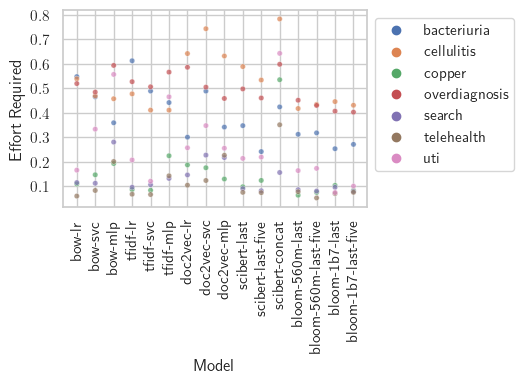

In [14]:
model_names = []

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)
        
transformer_models = [
    "scibert-last",
    "scibert-last-five",
    "scibert-concat",
    "bloom-560m-last",
    "bloom-560m-last-five",
    "bloom-1b7-last",
    "bloom-1b7-last-five"
]
for model in transformer_models:
    model_names.append(model)
    
def get_average_effort(efforts):
    # Return average
    standard_deviation = np.std(efforts, ddof=1)
    standard_error = standard_deviation / np.sqrt(np.size(efforts))
    average = sum(efforts) / len(efforts)
    return [average, standard_error, standard_deviation]
    
df_datasets = pd.DataFrame()
    
for dataset in datasets:
    efforts = []
    for model in model_names:
        efforts.append(get_effort(dataset, model, 1.0))
    df_datasets[dataset] = efforts
    
df_datasets["model_name"] = model_names
df_datasets.head(20)

df_datasets = pd.melt(df_datasets, id_vars="model_name", value_vars=datasets, var_name="dataset")
df_datasets.head()
    
fig = plt.figure()

sns.set_style("whitegrid")
ax = sns.scatterplot(data=df_datasets, x="model_name", y="value", hue="dataset",  marker="o", s=15, alpha=0.7)

ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_major_formatter('{x:.0f}')

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

plt.xlabel("Model")
ax.tick_params(axis='x', labelrotation = 90)

plt.ylabel("Effort Required")

plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.5)

fig.set_size_inches(w=5.39749, h=4)
fig.tight_layout()

# plt.savefig('../honours/thesis/Figures/effort-full-breakdown.pgf')
plt.show()

In [ ]:
df = sns.load_dataset("penguins")
df.head()
# sns.barplot(data=df, x="island", y="body_mass_g")

# Simple

In [ ]:
# Plot all models on one plot
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import numpy as np
from itertools import zip_longest

# Create nine polar axes and access them through the returned array
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
# Set common labels
fig.text(0.55, 0.02, 'Effort', ha='center', va='center')
fig.text(0.02, 0.4, 'Accuracy', ha='center', va='center', rotation='vertical')
sns.set(style="whitegrid")

embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]

for i, embedding in enumerate(embeddings):
	for j, classifier in enumerate(classifiers):
		for dataset in datasets:
			model = embedding + "-" + classifier
			stats_df = pd.read_csv("stats/stats-" + dataset + "-" + model + ".csv")
			# Convert csv lists to actual lists
			stats_df.effort = stats_df.effort.apply(literal_eval)
			stats_df.accuracy = stats_df.accuracy.apply(literal_eval)
			# Find longest effort array
			effort = max(stats_df.effort, key=len)
			# Average all accuracy data points over the 10 iterations
			avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()
			axs[i,j].plot(effort, avg_accuracy, label=dataset, linewidth=1.5)
			axs[i,j].set_title(model)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0,1),loc='upper left')
axs[0,0].set_xticks((np.arange(0, 0.8, 0.2)))
axs[0,0].set_yticks((np.arange(0.2, 1.01, 0.2)))
fig.set_size_inches(w=5.39749, h=6)
fig.tight_layout()

plt.subplots_adjust(left=0.1, bottom=0.08, top=0.69, right=1)

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-simple.pgf')
plt.show()

In [ ]:
# Plot bar plot of average model performance
colormap = [
    # Blues
    "#8495e0",
    "#4f68d6",
    "#1f39ab",
    # Greens
    "#92e0ad",
    "#3fbf6b",
    "#155e2e",
    # Oranges
    "#cfaa61",
    "#cc921f",
    "#9e6a03",
]

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bow", "tfidf", "doc2vec"]
classifiers=["lr", "svc", "mlp"]
model_names = []
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)

def get_average_effort_at_accuracy(model_name, accuracy):
    efforts = []
    for dataset in datasets:
        efforts.append(get_effort(dataset, model_name, accuracy))
    # Return average
    standard_deviation = np.std(efforts, ddof=1)
    standard_error = standard_deviation / np.sqrt(np.size(efforts))
    average = sum(efforts) / len(efforts)
    return [average, standard_error, standard_deviation]

accuracy_thresholds = [0.9, 0.95, 1]
x = np.arange(len(accuracy_thresholds))  # the label locations
width = 0.8 # the width of the bars
fig, ax = plt.subplots()
sns.set(style="whitegrid")
ax.xaxis.grid(False)
rects = []

length = len(model_names)
for i, model_name in enumerate(model_names):
    required_efforts = []
    standard_errors = []
    for accuracy in accuracy_thresholds:
        temp = get_average_effort_at_accuracy(model_name, accuracy)
        print("{} at {} accuracy: {:.2f} ({:.2f} S.E.)".format(model_name, accuracy, temp[0], temp[1]))
        required_efforts.append(temp[0])
        standard_errors.append(temp[1])
    
    color=colormap[i%9]
    i = i - len(model_names)/2 # Offset bar to left
    rects.append(ax.bar(x + i * (width/length), required_efforts, width/length, label=model_name, color=color, yerr=standard_errors))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy Threshold')
ax.set_ylabel('Required Effort')
ax.set_xticks(x, accuracy_thresholds)
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.legend(ncol=3, fontsize=10, loc='upper left')
# ax.legend()

# for rect in rects:
#     ax.bar_label(rect, padding=3, fmt='%.2f', verticalalignment='center', fontsize=8, rotation=90)

fig.set_size_inches(w=5.39749, h=4)
plt.yticks(np.arange(0, 0.61, 0.05))
fig.tight_layout()

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-simple-bar.pgf')
plt.show()

# SciBERT

In [ ]:
# Plot all models on one plot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from ast import literal_eval
import numpy as np
from itertools import zip_longest

# Create nine polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
axs[0, 1].axis('off')
# Set common labels
fig.text(0.55, 0.02, 'Effort', ha='center', va='center')
fig.text(0.02, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')
sns.set(style="whitegrid")

embeddings=["scibert"]
classifiers=["last", "average", "concat"]
datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]

for i, embedding in enumerate(embeddings):
    for j, classifier in enumerate(classifiers):
        i = math.ceil(j/2)
        j = j % 2
        for dataset in datasets:
            model = embedding + "-" + classifier
            stats_df = pd.read_csv("stats/stats-" + dataset + "-" + model + ".csv")
            # Convert csv lists to actual lists
            stats_df.effort = stats_df.effort.apply(literal_eval)
            stats_df.accuracy = stats_df.accuracy.apply(literal_eval)
            # Find longest effort array
            effort = max(stats_df.effort, key=len)
            # Average all accuracy data points over the 10 iterations
            avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()
            axs[i,j].plot(effort, avg_accuracy, label=dataset, linewidth=1.5)
            axs[i,j].set_title(model)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.6,0.95),loc='upper left')
axs[0,0].set_xticks((np.arange(0, 0.8, 0.2)))
axs[0,0].set_yticks((np.arange(0.2, 1.01, 0.2)))
fig.set_size_inches(w=5.39749, h=4)
fig.tight_layout()

plt.subplots_adjust(left=0.12, bottom=0.12, right=1)

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-scibert.pgf')
plt.show()

In [ ]:
# Plot bar plot of average model performance
colormap = [
    # Blues
    "#4f68d6",
    # Greens
    "#3fbf6b",
    # Oranges
    "#cc921f",
]

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["scibert"]
classifiers=["last", "average", "concat"]
model_names = []
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)

def get_average_effort_at_accuracy(model_name, accuracy):
    efforts = []
    for dataset in datasets:
        efforts.append(get_effort(dataset, model_name, accuracy))
    # Return average
    return sum(efforts) / len(efforts)

accuracy_thresholds = [0.9, 0.95, 1]
x = np.arange(len(accuracy_thresholds))  # the label locations
width = 0.8 # the width of the bars
fig, ax = plt.subplots()
sns.set(style="whitegrid")
ax.xaxis.grid(False)
rects = []

length = len(model_names)
for i, model_name in enumerate(model_names):
    required_efforts = []
    for accuracy in accuracy_thresholds:
        required_efforts.append(get_average_effort_at_accuracy(model_name, accuracy))
    color=colormap[i%9]
    i = i - len(model_names)/3 # Offset bar to left
    rects.append(ax.bar(x + i * (width/length), required_efforts, width/length, label=model_name, color=color))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy Threshold')
ax.set_ylabel('Required Effort')
ax.set_xticks(x, accuracy_thresholds)
ax.legend(fontsize=10)

for rect in rects:
	ax.bar_label(rect, padding=3, fmt='%.2f', verticalalignment='center', rotation=90)

fig.set_size_inches(w=5.39749, h=3)
plt.yticks(np.arange(0, 0.61, 0.1))
fig.tight_layout()

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-scibert-bar.pgf')
plt.show()

# Bloom

In [ ]:
# Plot all models on one plot
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
import numpy as np
from itertools import zip_longest

# Create nine polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
# Set common labels
fig.text(0.42, 0.02, 'Effort', ha='center', va='center')
fig.text(0.02, 0.5, 'Accuracy', ha='center', va='center', rotation='vertical')
sns.set(style="whitegrid")

embeddings=["bloom-560m", "bloom-1b7"]
classifiers=["last", "average"]
datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]

for i, embedding in enumerate(embeddings):
    for j, classifier in enumerate(classifiers):
        for dataset in datasets:
            model = embedding + "-" + classifier
            stats_df = pd.read_csv("stats/stats-" + dataset + "-" + model + ".csv")
            # Convert csv lists to actual lists
            stats_df.effort = stats_df.effort.apply(literal_eval)
            stats_df.accuracy = stats_df.accuracy.apply(literal_eval)
            # Find longest effort array
            effort = max(stats_df.effort, key=len)
            # Average all accuracy data points over the 10 iterations
            avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()
            axs[i,j].plot(effort, avg_accuracy, label=dataset, linewidth=1.5)
            axs[i,j].set_title(model)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.72,0.95),loc='upper left')
axs[0,0].set_xticks((np.arange(0, 0.8, 0.2)))
axs[0,0].set_yticks((np.arange(0.2, 1.01, 0.2)))
fig.set_size_inches(w=5.39749, h=3.5)
fig.tight_layout()

plt.subplots_adjust(left=0.11, bottom=0.13, right=0.72)

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-bloom.pgf')
plt.show()

In [ ]:
# Plot bar plot of average model performance
colormap = [
	# Blues
	"#8495e0",
	"#1f39ab",
	# Greens
	"#92e0ad",
	"#155e2e",
]

datasets = ["bacteriuria", "cellulitis", "copper", "overdiagnosis", "search", "telehealth", "uti"]
embeddings=["bloom-560m", "bloom-1b7"]
classifiers=["last", "average"]
model_names = []
for embedding in embeddings:
    for classifier in classifiers:
        model_names.append(embedding + "-" + classifier)

def get_average_effort_at_accuracy(model_name, accuracy):
    efforts = []
    for dataset in datasets:
        efforts.append(get_effort(dataset, model_name, accuracy))
    # Return average
    return sum(efforts) / len(efforts)

accuracy_thresholds = [0.9, 0.95, 1]
x = np.arange(len(accuracy_thresholds))  # the label locations
width = 0.8 # the width of the bars
fig, ax = plt.subplots()
sns.set(style="whitegrid")
ax.xaxis.grid(False)
rects = []

length = len(model_names)
for i, model_name in enumerate(model_names):
    required_efforts = []
    for accuracy in accuracy_thresholds:
        required_efforts.append(get_average_effort_at_accuracy(model_name, accuracy))
    color=colormap[i%9]
    i = i - len(model_names)/2.6 # Offset bar to left
    rects.append(ax.bar(x + i * (width/length), required_efforts, width/length, label=model_name, color=color))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Accuracy Threshold')
ax.set_ylabel('Required Effort')
ax.set_xticks(x, accuracy_thresholds)
ax.legend(loc='upper left')

for rect in rects:
	ax.bar_label(rect, padding=3, fmt='%.2f', verticalalignment='center', rotation=90)

fig.set_size_inches(w=5.39749, h=3)
plt.yticks(np.arange(0, 0.51, 0.1))
fig.tight_layout()

plt.savefig('../honours/thesis/Figures/effort-accuracy-all-bloom-bar.pgf')
plt.show()